In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv


In [2]:
df = pd.read_csv("/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv")

In [3]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
df.isnull().sum()

review       0
sentiment    0
dtype: int64

In [5]:
df.duplicated().sum()

418

In [6]:
df=df.drop_duplicates(keep='first')


<Axes: xlabel='sentiment', ylabel='count'>

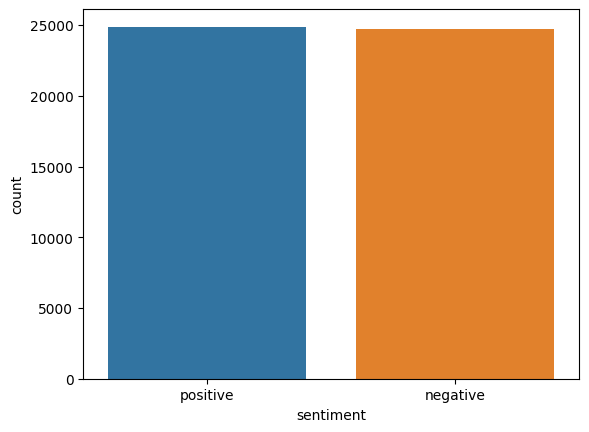

In [7]:
import seaborn as sns
sns.countplot(x='sentiment', data = df)

In [8]:
import re
import string
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

def preprocessing(text):
    text = text.lower()
    text = re.sub('<.*?>','', text)
    text = re.sub(r'https?://\S+|www\.\S+','', text)
    text = re.sub(r' [^\w\s]', '', text)
    text = re.sub(r'\@w+|\#','', text)
    PUNCT_TO_REMOVE = string.punctuation
    text = text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))
    stopWords = set(stopwords.words('english'))
    words = word_tokenize(text)
    wordsFiltered = [w for w in words if w not in stopWords]
    return " ".join(wordsFiltered)

In [9]:
df.review = df['review'].apply(preprocessing)

In [10]:
import nltk
from nltk.stem import WordNetLemmatizer
#!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

lemmatizer = WordNetLemmatizer()
df["review"] = df["review"].apply(lambda x: " ".join([lemmatizer.lemmatize(word) for word in x.split()]))


In [23]:
df.sentiment.replace('positive', 1, inplace=True)
df.sentiment.replace('negative', 0, inplace=True)

/tmp/ipykernel_844/1047689033.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.sentiment.replace('negative', 0, inplace=True)


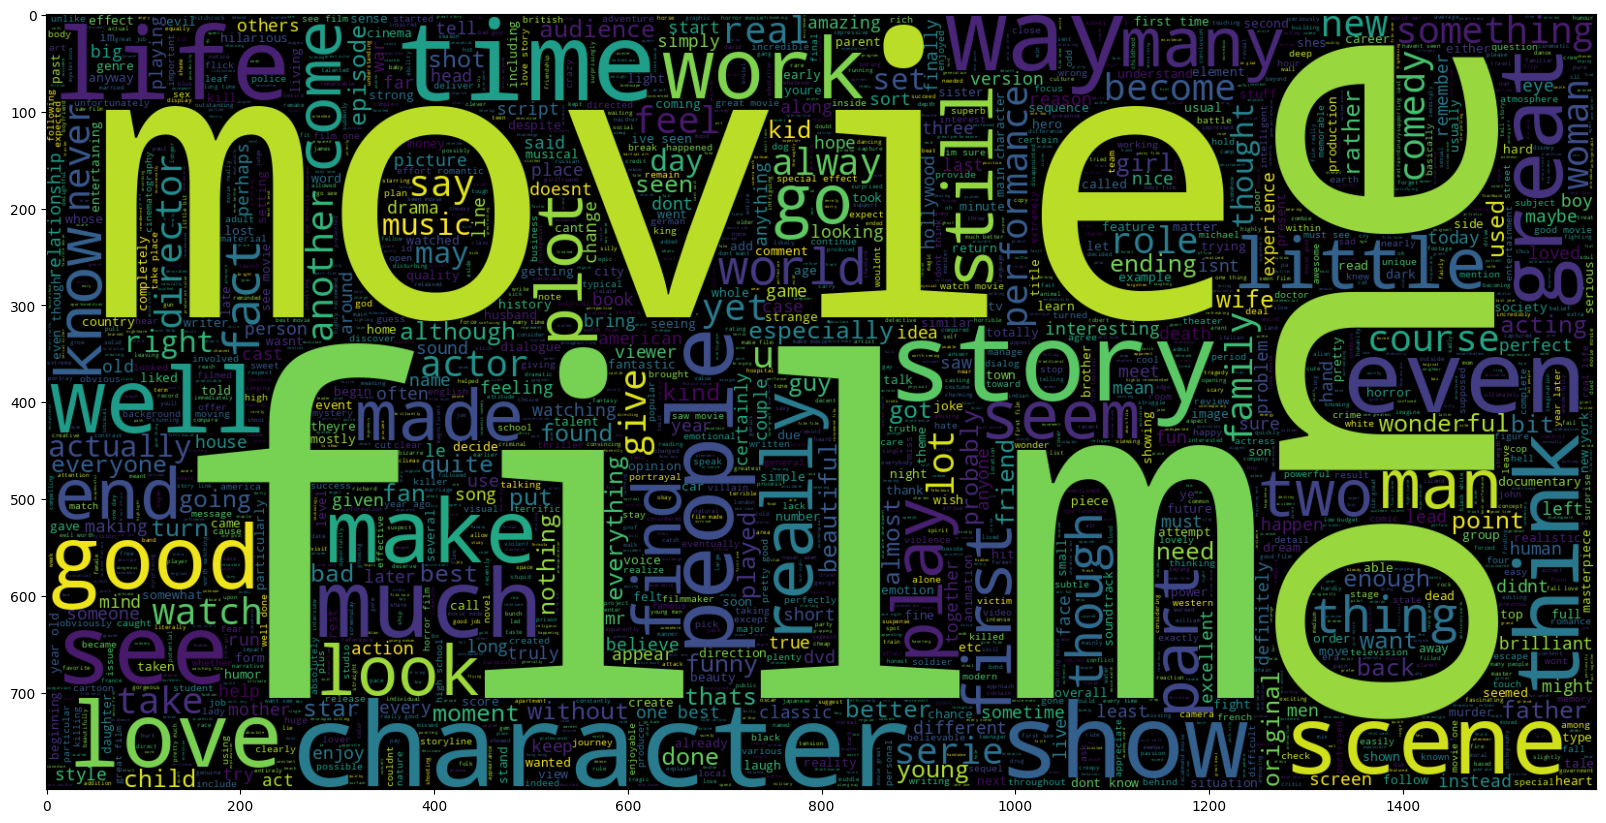

In [25]:
#Positive Sentiments WordCloud
import matplotlib.pyplot as plt 
from wordcloud import WordCloud,STOPWORDS
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(df[df.sentiment == 1].review))
plt.imshow(wc , interpolation = 'bilinear')

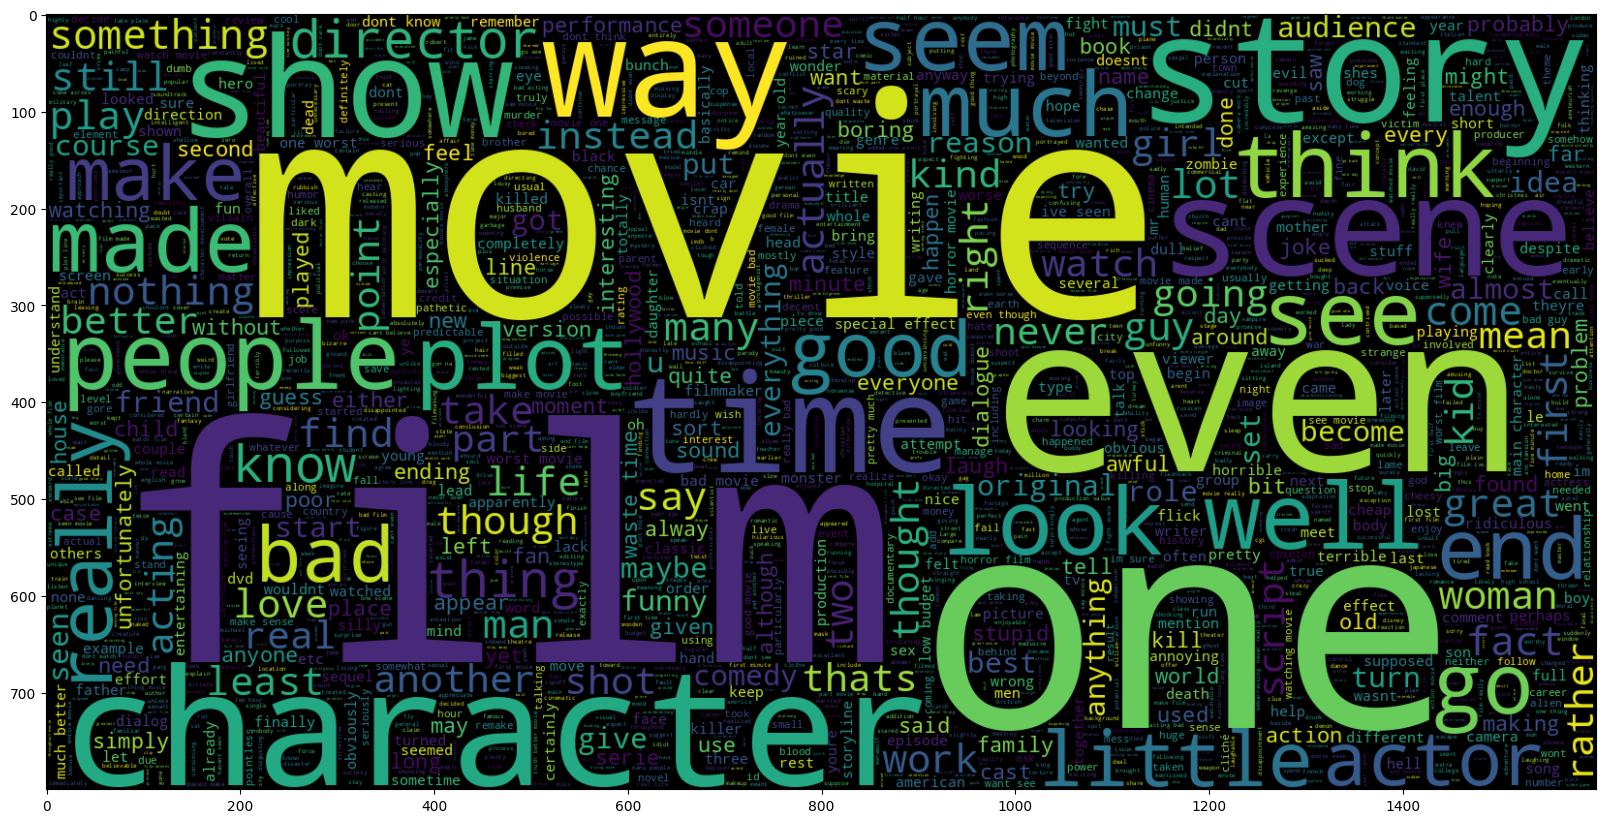

In [26]:
#Negative Sentiments WordCloud
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(df[df.sentiment == 0].review))
plt.imshow(wc , interpolation = 'bilinear')

In [36]:
from collections import Counter
count = Counter()
for text in df[df.sentiment == 1].review.values:
    for word in text.split():
        count[word] +=1
pos_words = pd.DataFrame(count.most_common(15))
pos_words.columns = ['words', 'count']

In [38]:
import plotly.express as px
px.bar(pos_words, x= 'count', y = 'words', title='Commom words in Positive Reviews',color = 'words')

/opt/conda/lib/python3.10/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



In [40]:
count = Counter()
for text in df[df.sentiment == 0].review.values:
    for word in text.split():
        count[word] +=1
neg_words = pd.DataFrame(count.most_common(15))
neg_words.columns = ['words', 'count']
px.bar(neg_words, x= 'count', y = 'words', title='Commom words in Negative Reviews', color = 'words')

/opt/conda/lib/python3.10/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



In [41]:
X = df['review']
Y = df['sentiment']

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer
vect = TfidfVectorizer()
X = vect.fit_transform(X)

In [51]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)


In [52]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [53]:
logreg = LogisticRegression()
logreg.fit(x_train, y_train)
logreg_pred = logreg.predict(x_test)
logreg_acc = accuracy_score(logreg_pred, y_test)
print("Test accuracy: {:.2f}%".format(logreg_acc*100))

Test accuracy: 89.31%


In [54]:
print(confusion_matrix(y_test, logreg_pred))
print("\n")
print(classification_report(y_test, logreg_pred))

[[6515  889]
 [ 701 6770]]


              precision    recall  f1-score   support

           0       0.90      0.88      0.89      7404
           1       0.88      0.91      0.89      7471

    accuracy                           0.89     14875
   macro avg       0.89      0.89      0.89     14875
weighted avg       0.89      0.89      0.89     14875



In [55]:

mnb = MultinomialNB()
mnb.fit(x_train, y_train)
mnb_pred = mnb.predict(x_test)
mnb_acc = accuracy_score(mnb_pred, y_test)
print("Test accuracy: {:.2f}%".format(mnb_acc*100))
print(confusion_matrix(y_test, mnb_pred))
print("\n")
print(classification_report(y_test, mnb_pred))


Test accuracy: 86.51%
[[6431  973]
 [1033 6438]]


              precision    recall  f1-score   support

           0       0.86      0.87      0.87      7404
           1       0.87      0.86      0.87      7471

    accuracy                           0.87     14875
   macro avg       0.87      0.87      0.87     14875
weighted avg       0.87      0.87      0.87     14875



In [56]:
svc = LinearSVC()
svc.fit(x_train, y_train)
svc_pred = svc.predict(x_test)
svc_acc = accuracy_score(svc_pred, y_test)
print("Test accuracy: {:.2f}%".format(svc_acc*100))
print(confusion_matrix(y_test, svc_pred))
print("\n")
print(classification_report(y_test, svc_pred))

Test accuracy: 89.45%
[[6559  845]
 [ 724 6747]]


              precision    recall  f1-score   support

           0       0.90      0.89      0.89      7404
           1       0.89      0.90      0.90      7471

    accuracy                           0.89     14875
   macro avg       0.89      0.89      0.89     14875
weighted avg       0.89      0.89      0.89     14875

